In [122]:
import pandas as pd
import tensorflow as tf
import sklearn 
#import scikitplot 
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model
from keras.utils import to_categorical
import os
from pickle import dump,load
from tqdm.notebook import tqdm as tqdm
import skfuzzy
from tensorflow.keras.layers import Layer,Input,Dense
from tensorflow.keras.models import Model
import keras
import sys
import numpy
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import train_test_split

In [124]:
class FuzzyLayer(Layer):
    def __init__(self, output_dim, **kwargs):
        super(FuzzyLayer, self).__init__(**kwargs)
        self.output_dim = output_dim
    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel',
            shape=(input_shape[1], self.output_dim),
            initializer='uniform',
            trainable=True)
    def call(self, x):
        return tf.math.sigmoid(tf.matmul(x, self.kernel))

In [3]:
import warnings
warnings.filterwarnings('ignore')



In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


In [5]:
cols = [' Bwd Packet Length Std',' PSH Flag Count',' min_seg_size_forward',' Min Packet Length',' ACK Flag Count',' Bwd Packet Length Min',' Fwd IAT Std','Init_Win_bytes_forward',' Flow IAT Max',' Bwd Packets/s',' URG Flag Count','Bwd IAT Total',' Label']
df1=pd.read_csv("dataset/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv", usecols = cols)#,nrows = 50000
df2=pd.read_csv("dataset/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv", usecols = cols)
df3=pd.read_csv("dataset/Friday-WorkingHours-Morning.pcap_ISCX.csv", usecols = cols)
df4=pd.read_csv("dataset/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv", usecols = cols)
df5=pd.read_csv("dataset/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv", usecols = cols)


In [6]:
df = pd.concat([df1,df2])
del df1,df2
df = pd.concat([df,df3])
del df3
df = pd.concat([df,df4])
del df4
df = pd.concat([df,df5])
del df5

data = df.copy()

In [7]:
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
df.head()


,bwd_packet_length_min,bwd_packet_length_std,flow_iat_max,fwd_iat_std,bwd_iat_total,bwd_packets/s,min_packet_length,psh_flag_count,ack_flag_count,urg_flag_count,init_win_bytes_forward,min_seg_size_forward,label
0,0,0.0,3,0.0,0,0.000000,6,0,1,0,33,20,BENIGN
1,6,0.0,109,0.0,0,9174.311927,6,0,1,1,29,20,BENIGN
2,6,0.0,52,0.0,0,19230.769230,6,0,1,1,29,20,BENIGN
3,6,0.0,34,0.0,0,29411.764710,6,0,1,1,31,20,BENIGN
4,0,0.0,3,0.0,0,0.000000,6,0,1,0,32,20,BENIGN


In [8]:
df_cleaned = df.copy()
df_cleaned.replace([np.inf], 999999, inplace=True)
df_cleaned.replace([-np.inf], -999999, inplace=True)
df_cleaned.replace([np.nan], 0, inplace=True)




In [9]:
df_cleaned.head()

,bwd_packet_length_min,bwd_packet_length_std,flow_iat_max,fwd_iat_std,bwd_iat_total,bwd_packets/s,min_packet_length,psh_flag_count,ack_flag_count,urg_flag_count,init_win_bytes_forward,min_seg_size_forward,label
0,0,0.0,3,0.0,0,0.000000,6,0,1,0,33,20,BENIGN
1,6,0.0,109,0.0,0,9174.311927,6,0,1,1,29,20,BENIGN
2,6,0.0,52,0.0,0,19230.769230,6,0,1,1,29,20,BENIGN
3,6,0.0,34,0.0,0,29411.764710,6,0,1,1,31,20,BENIGN
4,0,0.0,3,0.0,0,0.000000,6,0,1,0,32,20,BENIGN


In [10]:
df_cleaned = df_cleaned.reset_index()
df_cleaned.drop('index', axis=1, inplace=True)


In [11]:
df_labels = df_cleaned['label']
df_labels.unique()

array(['BENIGN', 'DDoS', 'PortScan', 'Bot', 'Infiltration',
       'Web Attack � Brute Force', 'Web Attack � XSS',
       'Web Attack � Sql Injection'], dtype=object)

In [12]:
df_no_labels = df_cleaned.drop('label', axis=1, inplace=False)
df_features = df_no_labels.columns.tolist()


In [13]:
scaler = MinMaxScaler()

In [14]:
df_scaled = MinMaxScaler().fit_transform(df_no_labels)
df_scaled = pd.DataFrame(data = df_scaled, columns = df_features)


In [15]:
dump(scaler, open('scaler.pkl','wb'))

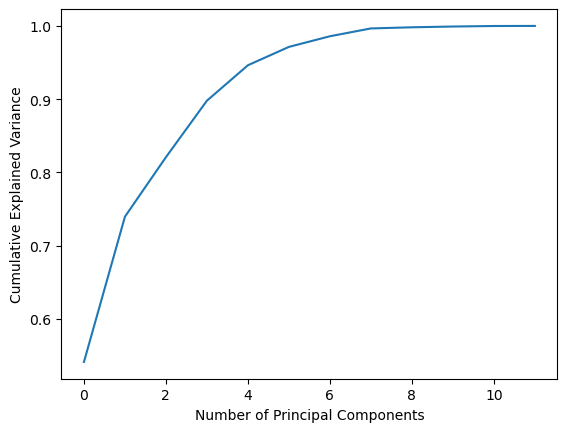

In [21]:
pca_test = PCA().fit(df_scaled)
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

In [22]:
pca = PCA(n_components=9)
principal_components = pca.fit(df_no_labels).transform(df_no_labels)
principal_components

array([[-9.46520183e+06, -1.73997806e+06, -6.19956101e+04, ...,
        -5.61635498e+01, -1.93961924e+00,  4.17752206e+00],
       [-9.46516112e+06, -1.73988700e+06, -6.20287915e+04, ...,
        -4.91017965e+01, -3.27540029e+00,  4.31239176e+00],
       [-9.46518479e+06, -1.73993722e+06, -6.20120548e+04, ...,
        -4.77243233e+01, -3.10608534e+00,  4.38553735e+00],
       ...,
       [-8.67531179e+06, -1.04532875e+06, -1.99837746e+05, ...,
        -1.28081944e+01, -1.38435130e+00, -1.62757408e+00],
       [-9.46512194e+06, -1.73980176e+06, -6.20585363e+04, ...,
        -5.64491211e+01, -7.47258269e+00, -7.81930917e+00],
       [-9.46518752e+06, -1.73994199e+06, -6.20126742e+04, ...,
        -5.16976769e+01, -6.88971045e+00, -7.57444184e+00]])

In [23]:
def get_PCA_feature_names(num_of_pca_components):
    feature_names = []
    for i in range(num_of_pca_components):    
        feature_names.append(f"Principal component {i+1}")
    return feature_names

In [24]:
principal_component_headings = get_PCA_feature_names(9)
principal_component_headings

['Principal component 1',
 'Principal component 2',
 'Principal component 3',
 'Principal component 4',
 'Principal component 5',
 'Principal component 6',
 'Principal component 7',
 'Principal component 8',
 'Principal component 9']

In [25]:
df_scaled.head()

,bwd_packet_length_min,bwd_packet_length_std,flow_iat_max,fwd_iat_std,bwd_iat_total,bwd_packets/s,min_packet_length,psh_flag_count,ack_flag_count,urg_flag_count,init_win_bytes_forward,min_seg_size_forward
0,0.000000,0.0,1.333333e-07,0.0,0.0,0.000000,0.004415,0.0,1.0,0.0,0.000519,0.333333
1,0.003661,0.0,1.016667e-06,0.0,0.0,0.004587,0.004415,0.0,1.0,1.0,0.000458,0.333333
2,0.003661,0.0,5.416666e-07,0.0,0.0,0.009615,0.004415,0.0,1.0,1.0,0.000458,0.333333
3,0.003661,0.0,3.916666e-07,0.0,0.0,0.014706,0.004415,0.0,1.0,1.0,0.000488,0.333333
4,0.000000,0.0,1.333333e-07,0.0,0.0,0.000000,0.004415,0.0,1.0,0.0,0.000504,0.333333


In [27]:
n_pcs= pca.components_.shape[0]
n_pcs

9

In [28]:

most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]

initial_feature_names = df_no_labels.columns


most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

dic = {'PC{}'.format(i+1): most_important_names[i] for i in range(n_pcs)}


df = pd.DataFrame(sorted(dic.items()))

In [29]:

df.head(9)

,0,1
0,PC1,bwd_iat_total
1,PC2,flow_iat_max
2,PC3,fwd_iat_std
3,PC4,bwd_packets/s
4,PC5,init_win_bytes_forward
5,PC6,bwd_packet_length_std
6,PC7,bwd_packet_length_min
7,PC8,min_packet_length
8,PC9,min_seg_size_forward


In [30]:

df_scaled.head()

,bwd_packet_length_min,bwd_packet_length_std,flow_iat_max,fwd_iat_std,bwd_iat_total,bwd_packets/s,min_packet_length,psh_flag_count,ack_flag_count,urg_flag_count,init_win_bytes_forward,min_seg_size_forward
0,0.000000,0.0,1.333333e-07,0.0,0.0,0.000000,0.004415,0.0,1.0,0.0,0.000519,0.333333
1,0.003661,0.0,1.016667e-06,0.0,0.0,0.004587,0.004415,0.0,1.0,1.0,0.000458,0.333333
2,0.003661,0.0,5.416666e-07,0.0,0.0,0.009615,0.004415,0.0,1.0,1.0,0.000458,0.333333
3,0.003661,0.0,3.916666e-07,0.0,0.0,0.014706,0.004415,0.0,1.0,1.0,0.000488,0.333333
4,0.000000,0.0,1.333333e-07,0.0,0.0,0.000000,0.004415,0.0,1.0,0.0,0.000504,0.333333


In [17]:
df_final=df_scaled[["bwd_iat_total","flow_iat_max","fwd_iat_std","bwd_packets/s","init_win_bytes_forward","bwd_packet_length_std","bwd_packet_length_min","min_packet_length","min_seg_size_forward"]]

In [18]:
df_labels.unique()

array(['BENIGN', 'DDoS', 'PortScan', 'Bot', 'Infiltration',
       'Web Attack � Brute Force', 'Web Attack � XSS',
       'Web Attack � Sql Injection'], dtype=object)

In [19]:
df_final.head().transpose()

,0,1,2,3,4
bwd_iat_total,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
flow_iat_max,1.333333e-07,0.000001,5.416666e-07,3.916666e-07,1.333333e-07
fwd_iat_std,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
bwd_packets/s,0.000000e+00,0.004587,9.615385e-03,1.470588e-02,0.000000e+00
init_win_bytes_forward,5.187988e-04,0.000458,4.577637e-04,4.882812e-04,5.035400e-04
bwd_packet_length_std,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
bwd_packet_length_min,0.000000e+00,0.003661,3.660769e-03,3.660769e-03,0.000000e+00
min_packet_length,4.415011e-03,0.004415,4.415011e-03,4.415011e-03,4.415011e-03
min_seg_size_forward,3.333333e-01,0.333333,3.333333e-01,3.333333e-01,3.333333e-01


In [26]:
mapping = {}
j = 0
for x in df_labels.unique():
    mapping[x]=j
    j=j+1

mapping

{'BENIGN': 0,
 'DDoS': 1,
 'PortScan': 2,
 'Bot': 3,
 'Infiltration': 4,
 'Web Attack � Brute Force': 5,
 'Web Attack � XSS': 6,
 'Web Attack � Sql Injection': 7}

In [28]:
r_mapping = {v:k for k,v in mapping.items()}

In [29]:
labels=[]
for x in df_labels:
    labels.append(mapping[x])

In [30]:
y = to_categorical(labels)

In [31]:
y.shape

(1162213, 8)

In [284]:
df_final.shape

(1162213, 9)

In [78]:
X = np.array(df_final)
X_train, X_test, y_train, y_test, labels_train, labels_test = train_test_split(X, y, labels, test_size=0.01)

In [125]:
input_layer = Input(shape=(9,))
fuzzy_layer = FuzzyLayer(64)(input_layer)
hidden_layer_1 = Dense(32, activation='tanh')(fuzzy_layer)
hidden_layer_2 = Dense(16, activation='tanh')(hidden_layer_1)
hidden_layer_3 = Dense(8, activation='tanh')(hidden_layer_2)
output_layer = Dense(8)(hidden_layer_3)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'accuracy'])

In [130]:
model.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 9)]               0         
                                                                 
 fuzzy_layer_18 (FuzzyLayer)  (None, 64)               576       
                                                                 
 dense_78 (Dense)            (None, 32)                2080      
                                                                 
 dense_79 (Dense)            (None, 16)                528       
                                                                 
 dense_80 (Dense)            (None, 8)                 136       
                                                                 
 dense_81 (Dense)            (None, 8)                 72        
                                                                 
Total params: 3,392
Trainable params: 3,392
Non-trainable 

In [127]:
checkpoint_filepath = '/Users/ege/Projects/IDS/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [128]:
history = model.fit(X_train, y_train,
        epochs=20,
        verbose=1,
        batch_size=64, callbacks=[model_checkpoint_callback] , validation_split=0.2)

Epoch 1/20
14383/14383 [==============================] - 12s 783us/step - loss: 0.0195 - mae: 0.0492 - accuracy: 0.8964 - val_loss: 0.0106 - val_mae: 0.0247 - val_accuracy: 0.9525
Epoch 2/20
14383/14383 [==============================] - 12s 839us/step - loss: 0.0086 - mae: 0.0210 - accuracy: 0.9538 - val_loss: 0.0072 - val_mae: 0.0185 - val_accuracy: 0.9620
Epoch 3/20
14383/14383 [==============================] - 12s 804us/step - loss: 0.0070 - mae: 0.0172 - accuracy: 0.9622 - val_loss: 0.0064 - val_mae: 0.0159 - val_accuracy: 0.9670
Epoch 4/20
14383/14383 [==============================] - 11s 794us/step - loss: 0.0066 - mae: 0.0164 - accuracy: 0.9655 - val_loss: 0.0063 - val_mae: 0.0152 - val_accuracy: 0.9672
Epoch 5/20
14383/14383 [==============================] - 11s 773us/step - loss: 0.0064 - mae: 0.0159 - accuracy: 0.9667 - val_loss: 0.0071 - val_mae: 0.0164 - val_accuracy: 0.9627
Epoch 6/20
14383/14383 [==============================] - 11s 779us/step - loss: 0.0063 - mae: 

In [131]:
model.load_weights(checkpoint_filepath)

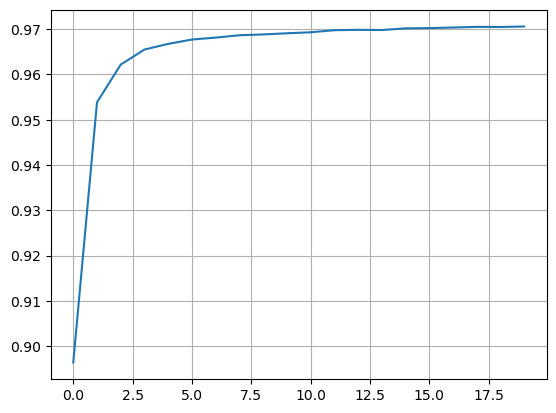

In [129]:
plt.plot(history.history['accuracy'][:])
plt.grid()

In [137]:
model.save('Detection_model.keras')
model.save('IDS_model.h5',save_format='h5')